In [9]:
from easydict import EasyDict as edict
import json
import nltk
import pickle
from collections import Counter
from pycocotools.coco import COCO

In [10]:
args = edict({
    "caption_path": './data/annotations/captions_train2014.json',
    "vocab_path": './data/annotations/vocab.pkl',
    "threshold": 4,
})

## 导入数据

In [11]:
coco = COCO(args.caption_path)
ids = coco.anns.keys()   # type(ids) is dict_keys

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


### Q: what is ids?
coco.anns 中的anns是一个字典，这个字典以每一个caption的id为key, 以整个annotation为value   
例如：  
{48: {'caption': 'A very clean and well decorated empty bathroom', 'id': 48, 'image_id': 318556},  
 67: {'caption': 'A panoramic view of a kitchen and all of its appliances.', 'id': 67, 'image_id': 116100},  
 126: {'caption': 'A blue and white bathroom with butterfly themed wall tiles.', 'id': 126, 'image_id': 318556},  
 ... ...}  
 故ids是这个dict的key的集合 

In [14]:
# 这段代码与上一个Cell实现功能相同

def anno_loader(json_file):

    dataset = json.load(open(json_file, 'r'))
    anns = {}
    if 'annotations' in dataset:
        for ann in dataset['annotations']:
            anns[ann['id']] = ann
    return anns

anns = anno_loader(args.caption_path)
ids = anns.keys()

## 统计词频

In [22]:
counter = Counter()
for i, id_ in enumerate(ids):
    caption = str(anns[id_]['caption'])
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)
# caption 是一个句子，tokens是将caption拆分为单词的字符串列表

tokenize api: https://www.nltk.org/api/nltk.tokenize.html  
word_tokenize: 
1. 带有连字符的复合单词不会被拆分
2. 单词后的任何符号都会被拆分
3. 单词前的任何符号的不会被拆分，比如：I'm 仅分为 ‘I’和 ‘'m’  

例子如下：

In [40]:
nltk.tokenize.word_tokenize("i'm trying, any-thing, /hahaha")

['i', "'m", 'trying', ',', 'any-thing', ',', '/hahaha']

## 设定词频数阈值，得到最后词汇列表

In [24]:
# If the word frequency is less than 'threshold', then the word is discarded.
words = [word for word, cnt in counter.items() if cnt >= args.threshold]
len(words)

9952

## 构建Vocabulary类
注意，无论是建立词库，还是导出词库，都需要声明这个类，否则Vocabulary类型的数据无法使用  
（之前在这里卡住了）

In [25]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

## 将words 加入词库

In [26]:
# Create a vocab wrapper and add some special tokens.
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

# Add the words to the vocabulary.
for i, word in enumerate(words):
    vocab.add_word(word)

## 存储为pkl文件

In [29]:
with open(args.vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(args.vocab_path))

Total vocabulary size: 9956
Saved the vocabulary wrapper to './data/annotations/vocab.pkl'


## 总结上面的步骤

In [4]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
        
    with open(args.vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(args.vocab_path))

    return None

## 读取pkl文件
pickle: https://docs.python.org/3/library/pickle.html  
注意：读取这个pkl是需要导入Vocabulary类的，因为存储的数据是Vocabulary类型的

In [32]:
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [33]:
len(vocab)

9956

In [36]:
vocab.word2idx['people']

52

In [37]:
vocab.idx2word[52]

'people'

## 验证数据

In [39]:
import json

annFile=args.caption_path

anno_data =open(annFile).read()
data = json.loads(anno_data)
for item in data:
    print(item)

info
images
licenses
annotations


#### coco caption 的annptations文件（json file）包含四个key：
1. info: 数据集的版本，创建时间等
2. images: 包含图片的id、宽高、文件名等（图片文件存储在单独的文件夹，png格式）
3. licenses: 数据集的licenses
4. annotations: 这个类型中的annotation用来存储描述图片的语句。每个语句描述了对应图片的内容，而每个图片至少有5个描述语句（有的图片更多）,  包含id、image_id、caption三个key

In [41]:
coco = COCO(args.caption_path)
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [44]:
from PIL import Image
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Image_id: 318556, Caption: A very clean and well decorated empty bathroom


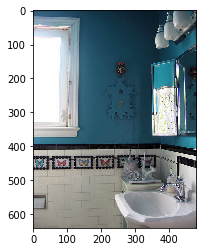

In [46]:
ann_id = ids[0]
caption = coco.anns[ann_id]['caption']
img_id = coco.anns[ann_id]['image_id']
path = coco.loadImgs(img_id)[0]['file_name']

image = Image.open(os.path.join('./data/train2014', path)).convert('RGB')
print("Image_id: {}, Caption: {}".format(img_id, caption))
imshow(image)